In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from datetime import datetime
!pip install -q category_encoders
import category_encoders as ce
from joblib import dump, load
import os 
import json

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

raw_dataset = pd.read_csv('/content/drive/MyDrive/Projects/Sentium/raw_data.csv')
print('raw_dataset.shape:', raw_dataset.shape)

### Filling missing values and drop duplicates

In [4]:
df = raw_dataset.copy()
print('len(df):', len(df))
print('df.isna().sum():', df.isna().sum())
df = df.drop_duplicates()
print('len(df):', len(df))
df.tail(2)

len(df): 690063
len(df): 241007


,address,type,bedrooms,latitude,longitude,area,price,tenure,is_newbuild,date
690061,"10, Little Bornes, London, Greater London SE21...",Flat,19,51.43061,-0.08388,SE21,717500,Freehold,0,2019-11-11 00:00:00+00:00
690062,"10, Little Bornes, London, Greater London SE21...",Flat,19,51.43061,-0.08388,SE21,365000,Freehold,0,2006-09-07 00:00:00+00:00


In [5]:
df['address'] = df['address'].apply(lambda s: s.lower())
df['type'] = df['type'].apply(lambda s: s.lower())
df['area'] = df['area'].apply(lambda s: s.lower())
df['tenure'] = df['tenure'].apply(lambda s: s.lower())

# extract feature from address 
df['street_name'] = df['address'].apply(lambda s: s.split(',')[-3].strip())

# extract feature from date
df['age_in_days'] = df['date'].apply(lambda d: (datetime.today() - datetime.strptime(d, '%Y-%m-%d %H:%M:%S%z').replace(tzinfo=None)).days)
df.drop(['address', 'date'], axis=1, inplace=True)

### Split the data into training and test sets

In [6]:
train_dataset = df.sample(frac=0.8, random_state=0)
test_dataset = df.drop(train_dataset.index)


train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('price')
test_labels = test_features.pop('price')

### Handle categoricals

In [9]:
from category_encoders.hashing import HashingEncoder

selected_columns_for_HashEncode =  ['street_name']
hash_encoder = HashingEncoder(cols= selected_columns_for_HashEncode, n_components=14, return_df=True, verbose=0)
train_features = hash_encoder.fit_transform(train_features)
train_features.head(2)

,col_0,col_1,col_2,col_3,col_4,col_5,col_6,col_7,col_8,col_9,col_10,col_11,col_12,col_13,type,bedrooms,latitude,longitude,area,tenure,is_newbuild,age_in_days
312507,0,0,0,0,0,0,1,0,0,0,0,0,0,0,terraced,2,51.45209,0.06009,se9,freehold,0,639
214755,0,0,0,0,0,0,0,0,0,0,0,1,0,0,flat,2,51.46960,-0.13135,sw4,leasehold,0,7793


In [10]:
selected_columns_for_OneHot =  ['type','tenure', 'area']
one_hot_encoder = ce.OneHotEncoder(cols= selected_columns_for_OneHot,return_df=True)
train_features = one_hot_encoder.fit_transform(train_features)
train_features.head(2)

,col_0,col_1,col_2,col_3,col_4,col_5,col_6,col_7,col_8,col_9,col_10,col_11,col_12,col_13,type_1,type_2,type_3,type_4,bedrooms,latitude,longitude,area_1,area_2,area_3,area_4,area_5,area_6,area_7,area_8,area_9,area_10,area_11,area_12,area_13,area_14,area_15,area_16,area_17,area_18,area_19,...,area_77,area_78,area_79,area_80,area_81,area_82,area_83,area_84,area_85,area_86,area_87,area_88,area_89,area_90,area_91,area_92,area_93,area_94,area_95,area_96,area_97,area_98,area_99,area_100,area_101,area_102,area_103,area_104,area_105,area_106,area_107,area_108,area_109,area_110,area_111,area_112,tenure_1,tenure_2,is_newbuild,age_in_days
312507,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,2,51.45209,0.06009,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,639
214755,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,2,51.46960,-0.13135,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,7793


In [11]:
def ecode_input(df):
  df = hash_encoder.transform(df)
  df = one_hot_encoder.transform(df)
  return df

test_features = ecode_input(test_features)

In [12]:
test_results = {}

normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(np.array(train_features))
print(len((normalizer.mean.numpy())[0]))

callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=5,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=False,
    )

def build_and_compile_model(norm):
    model = keras.Sequential([
      norm,
      layers.Dense(256, activation='relu'),
      layers.Dense(128, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(32, activation='relu'),
      layers.Dense(1)
    ])

    model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
    return model

137


In [13]:
dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 137)              275       
 n)                                                              
                                                                 
 dense (Dense)               (None, 256)               35328     
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 32)                2080      
                                                                 
 dense_4 (Dense)             (None, 1)                 33        
                                                        

In [14]:
%%time
history = dnn_model.fit(
    train_features,
    train_labels,
    validation_split=0.2,
    # callbacks=[callback],
    verbose=1, epochs=100)

Epoch 1/100
4821/4821 [==============================] - 22s 4ms/step - loss: 193347.3125 - val_loss: 170961.2031
Epoch 2/100
4821/4821 [==============================] - 21s 4ms/step - loss: 169015.4531 - val_loss: 166403.1719
Epoch 3/100
4821/4821 [==============================] - 20s 4ms/step - loss: 165306.4688 - val_loss: 164570.7031
Epoch 4/100
4821/4821 [==============================] - 20s 4ms/step - loss: 162753.8594 - val_loss: 162260.0000
Epoch 5/100
4821/4821 [==============================] - 20s 4ms/step - loss: 160795.6562 - val_loss: 161512.2188
Epoch 6/100
4821/4821 [==============================] - 20s 4ms/step - loss: 158780.5781 - val_loss: 159384.4844
Epoch 7/100
4821/4821 [==============================] - 20s 4ms/step - loss: 156791.7188 - val_loss: 157952.8906
Epoch 8/100
4821/4821 [==============================] - 20s 4ms/step - loss: 155399.0156 - val_loss: 156869.5156
Epoch 9/100
4821/4821 [==============================] - 20s 4ms/step - loss: 154235.734

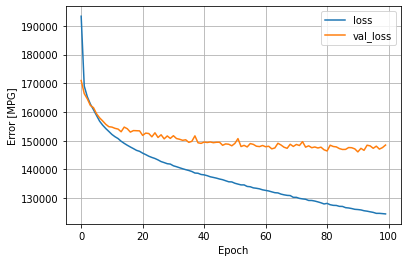

In [15]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    # plt.ylim([0, 10])
    plt.xlabel('Epoch')
    plt.ylabel('Error [MPG]')
    plt.legend()
    plt.grid(True)

plot_loss(history)

In [16]:
test_results['dnn_model'] = dnn_model.evaluate(test_features, test_labels, verbose=0)

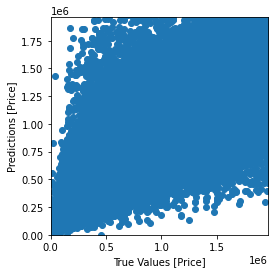

In [17]:
train_predictions = dnn_model.predict(train_features).flatten()

a = plt.axes(aspect='equal')
plt.scatter(train_labels, train_predictions)
plt.xlabel('True Values [Price]')
plt.ylabel('Predictions [Price]')
lims = [0, 1960868]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)
plt.show()

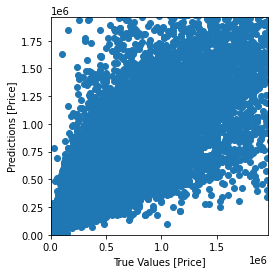

In [18]:
test_predictions = dnn_model.predict(test_features).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [Price]')
plt.ylabel('Predictions [Price]')
lims = [0, 1960868]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)
plt.show()

In [19]:
PROJECT_DIR = '/content/drive/MyDrive/Projects/Sentium/predict_house_price_model'
SAVED_MODEL_DIR = os.path.join(PROJECT_DIR, 'dnn_model')
HASH_ENCODER_DIR = os.path.join(PROJECT_DIR, 'hash_encoder.joblib')
ONE_HOT_ENCODER_DIR = os.path.join(PROJECT_DIR, 'one_hot_encoder.joblib')
METADATA_DIR = os.path.join(PROJECT_DIR, 'metadata.json')


dnn_model.save(
    SAVED_MODEL_DIR,
    overwrite=True,
    include_optimizer=True,
    save_format=None,
    signatures=None,
    options=None,
    save_traces=True,
)

dump(hash_encoder, HASH_ENCODER_DIR)
hash_encoder = load(HASH_ENCODER_DIR) 

dump(one_hot_encoder, ONE_HOT_ENCODER_DIR)
one_hot_encoder = load(ONE_HOT_ENCODER_DIR) 



reloaded = tf.keras.models.load_model(SAVED_MODEL_DIR)
test_results['reloaded'] = reloaded.evaluate(
    test_features, test_labels, verbose=2)

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Projects/Sentium/predict_house_price_model/dnn_model/assets
1507/1507 - 3s - loss: 153949.0625 - 3s/epoch - 2ms/step


In [20]:
metadata = {}
metadata['valid_values'] = {
    'area': sorted(df['area'].unique().tolist()),
    'type': sorted(df['type'].unique().tolist()),
    'tenure': sorted(df['tenure'].unique().tolist()),
}
metadata['columns'] = df.columns.tolist()
metadata['train_date'] = str(datetime.today())[:10]

import json
with open(METADATA_DIR, 'w') as fp:
    json.dump(metadata, fp)

# with open(METADATA_DIR, 'r') as f:
#     valid_values_dict = json.load(f)